In [1]:
%config InlineBackend.figure_formats = ['retina']

import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt

#Sklearn library
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn import tree,metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.utils import class_weight

#Library for OverSampling
from imblearn.over_sampling import RandomOverSampler

#Library for Neural Networks
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras import optimizers
from keras.utils.np_utils import to_categorical

# Load data

In [2]:
X = pd.read_csv('./data/hcvdat0.csv', index_col=0).reset_index(drop=True)

# Pre-processing

In this first part, we need to change the ``category`` attribute of the data because we need it to be int. In addition, we change the ``Sex`` attribute from m/f to $0/1$. All the other attributes are already floats, so we keep them as they are.

> m $\rightarrow 0$ and f $\rightarrow 1$

> Blood donor $\rightarrow 0$, Suspect blood donor $\rightarrow 1$, Hepatitis $\rightarrow 2$, Fibrosis $\rightarrow 3$ and Cirrhosis $\rightarrow 4$

## Change the sex and category attributes

In [3]:
class_names = np.unique(X.Category)
X = X.replace({'Sex': {'f':1,'m':0}, 'Category':{'0=Blood Donor':0,'0s=suspect Blood Donor':1, '1=Hepatitis':2, '2=Fibrosis':3, '3=Cirrhosis':4}})

## Remove NaN values

In [4]:
X = X.dropna()

## Split X and y

In [5]:
y = X.Category
X = X.drop('Category', axis=1)

## Class repartition

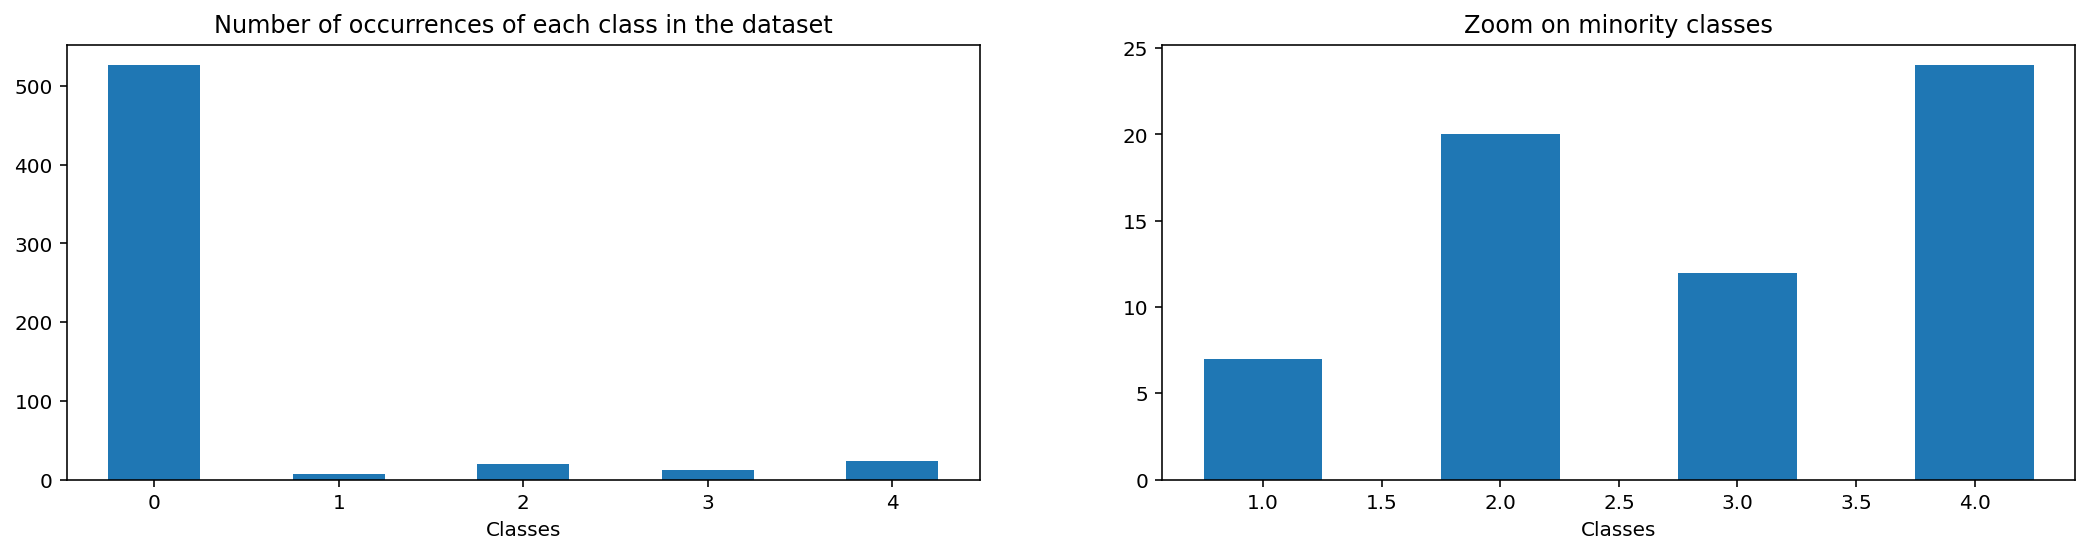

In [6]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
plt.hist(y.values,bins=range(0,6), align='left', rwidth=0.5)
plt.xlabel("Classes")
plt.title("Number of occurrences of each class in the dataset")

plt.subplot(1,2,2)
plt.hist(y[y!=0].values,bins=range(1,6), align='left', rwidth=0.5)
plt.xlabel("Classes")
plt.title("Zoom on minority classes")
plt.show()

The repartition of the different classes of the data set clearly shows an imbalanced situation. With a class 0 representing approximately 90% of the whole dataset, we can predict that we need to take this feature into account in order to avoid our classifier to only predict well this class.

## Split the data in train and test split

**Ensure that all classes are well distributed**\
Here we have to ensure that all classes are represented in both the training and the testing set. Indeed having a class only in the training set won't allow us to test its performance on new entries of the same class. And having a class only in the testing set will result in an impossibility to train on this specific class. \

To do so we can either do it manually of use a random state and check if the repartition is good (it is simpler and allows repeatability).

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=7)

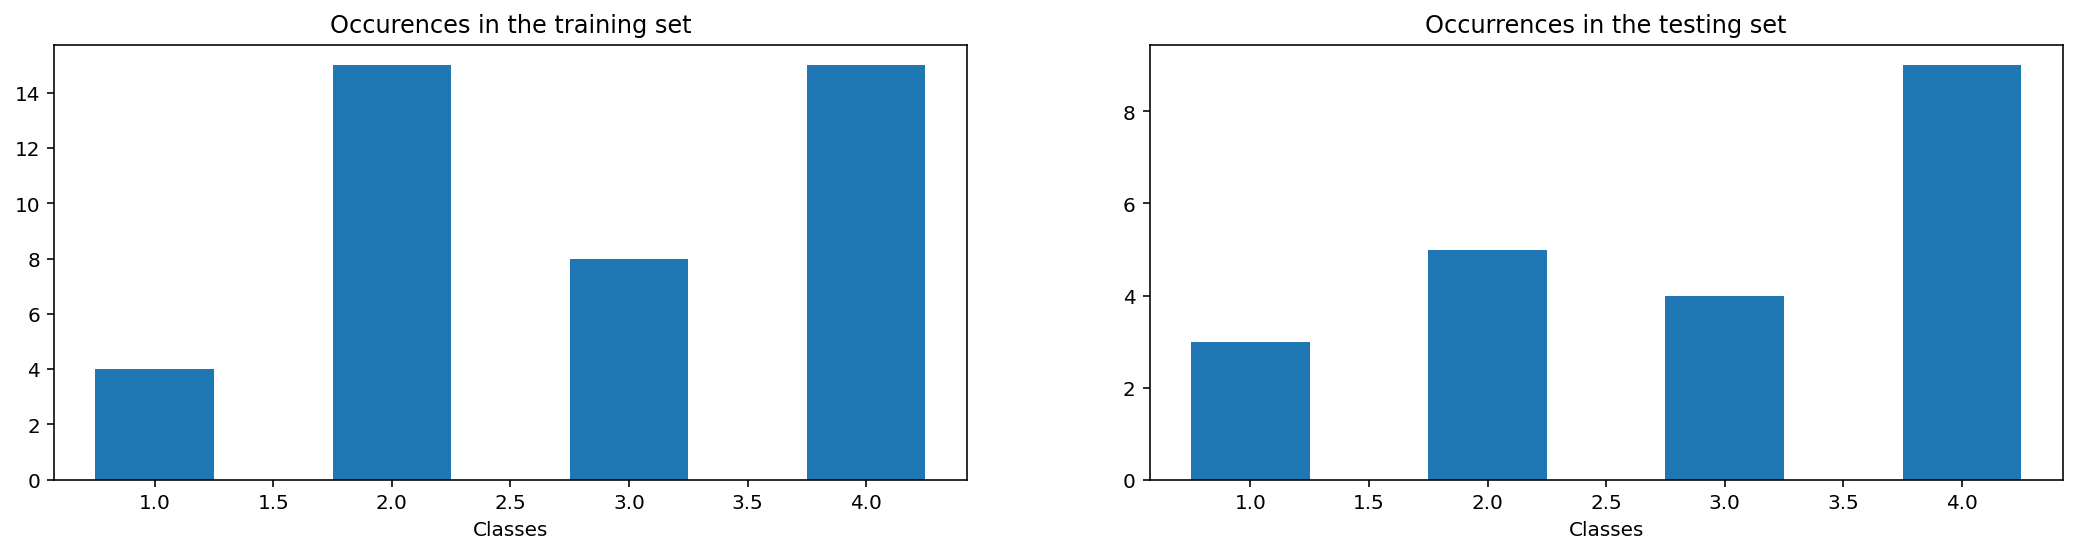

In [8]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
plt.hist(y_train[y_train!=0].values,bins=range(1,6), align='left', rwidth=0.5)
plt.xlabel("Classes")
plt.title("Occurences in the training set")

plt.subplot(1,2,2)
plt.hist(y_test[y_test!=0].values,bins=range(1,6), align='left', rwidth=0.5)
plt.xlabel("Classes")
plt.title("Occurrences in the testing set")
plt.show()

We didn't plot the repartition for the class 0 as it is good and we focused on the minority classes. In this case we see that the repartition is satisfactory especially for the class 1 that has in total only 7 occurences. We managed to have 5 of them in the training set.

## Normalise the data

In [9]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

## Over sampling smaller categories

**Balancing the dataset**\
One solution is to oversample the minority classes. To do so it is important not to touch to the testing set and to over sample on the training set. Indeed, if we had oversampled on the whole data set and then split the data, we could have been confronted to the case where we have records both in the training and testing set.\
The idea is to duplicate randomly ligns in the training set in order to have the same amount of records for each classes. We used the imblearn library that implemented the RandomOverSampler function.

In [10]:
#On fait attention ici de ne pas toucher aux test sets
x_train_eq,y_train_eq = RandomOverSampler().fit_resample(x_train,y_train)

In [11]:
oc = np.unique(y_train_eq,return_counts=True)
print("The number of occurrences for each class is now: {}".format(oc[1]))

The number of occurrences for each class is now: [370 370 370 370 370]


# Decision tree

## Tree without balancing data

In [12]:
test_DT = DecisionTreeClassifier(criterion='gini',random_state=1)
test_DT.fit(x_train,y_train)
print('Accuracy on the train set:', test_DT.score(x_train,y_train))
print('Accuracy on the test set:', test_DT.score(x_test,y_test))

Accuracy on the train set: 1.0
Accuracy on the test set: 0.9322033898305084


In [13]:
y_pred_test = test_DT.predict(x_test)
matrix = confusion_matrix(y_test, y_pred_test)
pred_class_test = matrix.diagonal()/matrix.sum(axis=1)

print("The accuracy for each class is: {}".format(pred_class_test.round(2)))

The accuracy for each class is: [0.99 0.33 0.2  0.25 0.78]


The prediction is not bad but we have to keep in mind that 90% of the data is of class 0. Looking at the accuracy for each class we see that the prediciton for each minority class is bad. The "good" score comes from the fact that the accuracy on the class 0 is very good.

## Build the tree

**Balancing the decision tree**\
We have to possibilities: either to use the balanced data set we created of to use the class weight parameter in the function implemented by sklearn.

In [75]:
clf = DecisionTreeClassifier(criterion='gini',class_weight='balanced',random_state=1)
clf.fit(x_train_eq, y_train_eq)

DecisionTreeClassifier(class_weight='balanced', random_state=1)

## Compute the accuracy of the tree

In [76]:
print('Accuracy on the train set:', clf.score(x_train, y_train))
print('Accuracy on the test set:', clf.score(x_test,y_test))

Accuracy on the train set: 1.0
Accuracy on the test set: 0.9322033898305084


In [77]:
print("The depth of this decision tree is {}".format(clf.tree_.max_depth))

The depth of this decision tree is 9


## Improving the accuracy ?

The depth of the tree is 10 and corresponds to the case where the score on the training set is 1. There might be some overfitting. One way to check if we can improve the testing score while not affecting too much the training score is to force a reduction of the depth of the tree. We can do that with a GridSearchCV.

In [105]:
grid_DT = {'max_depth':np.arange(1,10)}
DT_cv = GridSearchCV(DecisionTreeClassifier(),param_grid=grid_DT,cv=5)
DT_cv_res = DT_cv.fit(x_train_eq,y_train_eq)
DT_cv_res.best_params_

{'max_depth': 8}

In [109]:
print('Accuracy on the train set with depth reduction:', DT_cv.score(x_train_eq,y_train_eq))
print('Accuracy on the test set with depth reduction:', DT_cv.score(x_test,y_test))

Accuracy on the train set with depth reduction: 0.9994594594594595
Accuracy on the test set with depth reduction: 0.9322033898305084


The accuracy for each class is: [0.987 0.    0.6   0.5   0.667]


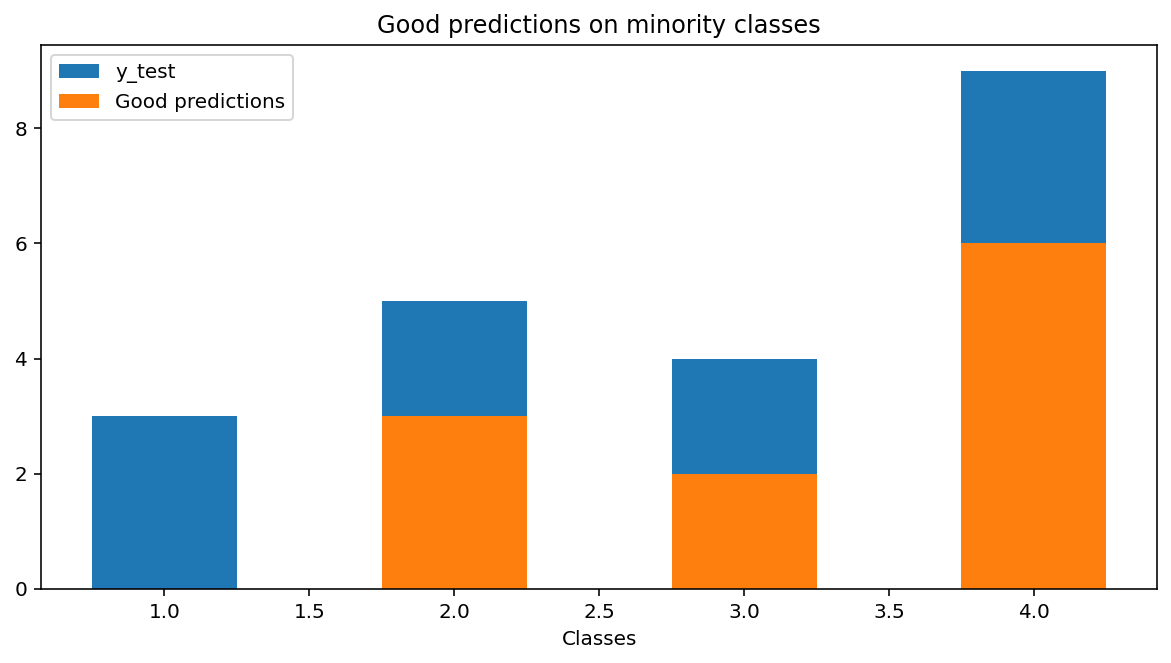

In [114]:
matrix_DT = confusion_matrix(y_test.values, DT_cv_res.predict(x_test))
acc_class_red = matrix_DT.diagonal()/matrix_DT.sum(axis=1)
print("The accuracy for each class is: {}".format(acc_class_red.round(3)))

plt.figure(figsize=(10,5))
plt.hist(y_test[y_test!=0].values,bins=range(1,6), align='left', rwidth=0.5,label='y_test')
plt.bar([1,2,3,4],matrix_DT.diagonal()[1:],color='C1',width = 0.5,label='Good predictions')
plt.xlabel("Classes")
plt.title("Good predictions on minority classes")
plt.legend()
plt.show()

This GridSearch doesn't affect much the score.
We observe an improvement on the minority classes. Expect for the class 1 and the class 4, the accucary has significantly increased for the class 2 and 3. For the fourth class the decrease is not significant.

## Visualise the tree

In [115]:
feature_names = X.columns
plot_tree = tree.export_graphviz(clf, out_file=None, filled=True,
                                 rounded=True, feature_names=feature_names, class_names=class_names)
graph = graphviz.Source(plot_tree)
#graph #Uncomment to show the decision tree

When plotting the tree we see that all classes have the same weight. It acts as if we had over sampled.

Use ``graph.render('name of the graph', view=True)`` when one wants to save the graph in a pdf file in the same directory as the one containing this notebook.

## Bagging

In [132]:
Bagging = BaggingClassifier(DecisionTreeClassifier(
    class_weight='balanced', max_depth=8), n_estimators=200)
#Here we use the parameter balanced to balance the class rather than using the data set we created as the results are better
Bagging.fit(x_train, y_train)
Bagging.score(x_test, y_test)

0.9378531073446328

In [133]:
bagging_grid = {'max_samples': np.arange(0.5, 1.0, 0.1)}
bagging_cv = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(
    class_weight='balanced', max_depth=8), n_estimators=200), param_grid=bagging_grid, cv=4)
#bagging_cv.fit(x_train_eq,y_train_eq) #to train on the oversampled training set
bagging_cv.fit(x_train, y_train)
bagging_cv.best_params_

{'max_samples': 0.8999999999999999}

In [134]:
print("Accuracy on the training set:",bagging_cv.score(x_train, y_train))
print("Accuracy on the testing set:",bagging_cv.score(x_test, y_test))

Accuracy on the training set: 1.0
Accuracy on the testing set: 0.943502824858757


The accuracy for each class is: [1.    0.    0.6   0.25  0.778]


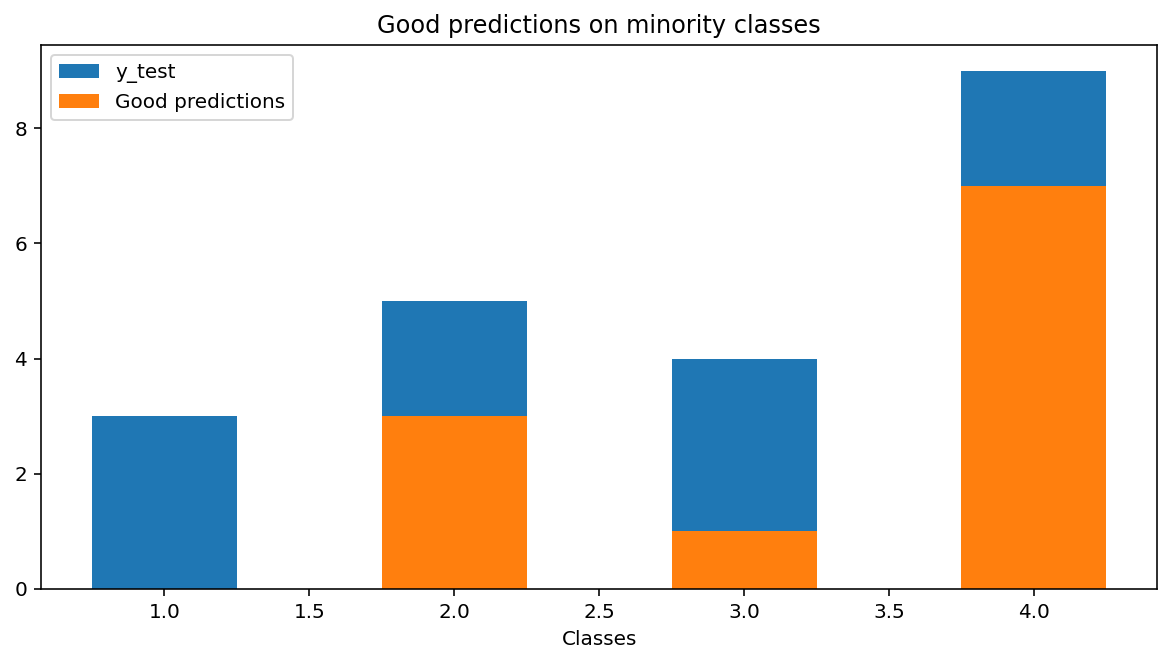

In [135]:
matrix_Bag = confusion_matrix(y_test.values, bagging_cv.predict(x_test))
acc_class_Bag = matrix_Bag.diagonal()/matrix_Bag.sum(axis=1)
print("The accuracy for each class is: {}".format(acc_class_Bag.round(3)))

plt.figure(figsize=(10,5))
plt.hist(y_test[y_test!=0].values,bins=range(1,6), align='left', rwidth=0.5,label='y_test')
plt.bar([1,2,3,4],matrix_Bag.diagonal()[1:],color='C1',width = 0.5,label='Good predictions')
plt.xlabel("Classes")
plt.title("Good predictions on minority classes")
plt.legend()
plt.show()

We observe a slight improvement on the overall testing score. But the accuracy on each class shows that some of them aren't well predicted.

## Random forest

In [136]:
RF = RandomForestClassifier(n_estimators=100,max_depth=9)
#It works better with our manually oversampled data set than with the class_weight option
RF.fit(x_train_eq, y_train_eq)
RF.score(x_test, y_test)

0.9491525423728814

In [137]:
param_RF = {'max_samples':np.arange(0.1,1.0,0.1)}
RF_cv = GridSearchCV(RandomForestClassifier(n_estimators=100),param_grid=param_RF,cv=5)
RF_cv.fit(x_train_eq,y_train_eq)
#RF_cv.fit(x_train,y_train)
RF_cv.best_params_

{'max_samples': 0.4}

In [138]:
print("Accuracy for the training set: ",RF_cv.score(x_train_eq,y_train_eq))
print("Accuracy for the testing set: ",RF_cv.score(x_test, y_test))

Accuracy for the training set:  1.0
Accuracy for the testing set:  0.9491525423728814


The accuracy for each class is: [1.   0.   0.4  0.25 1.  ]


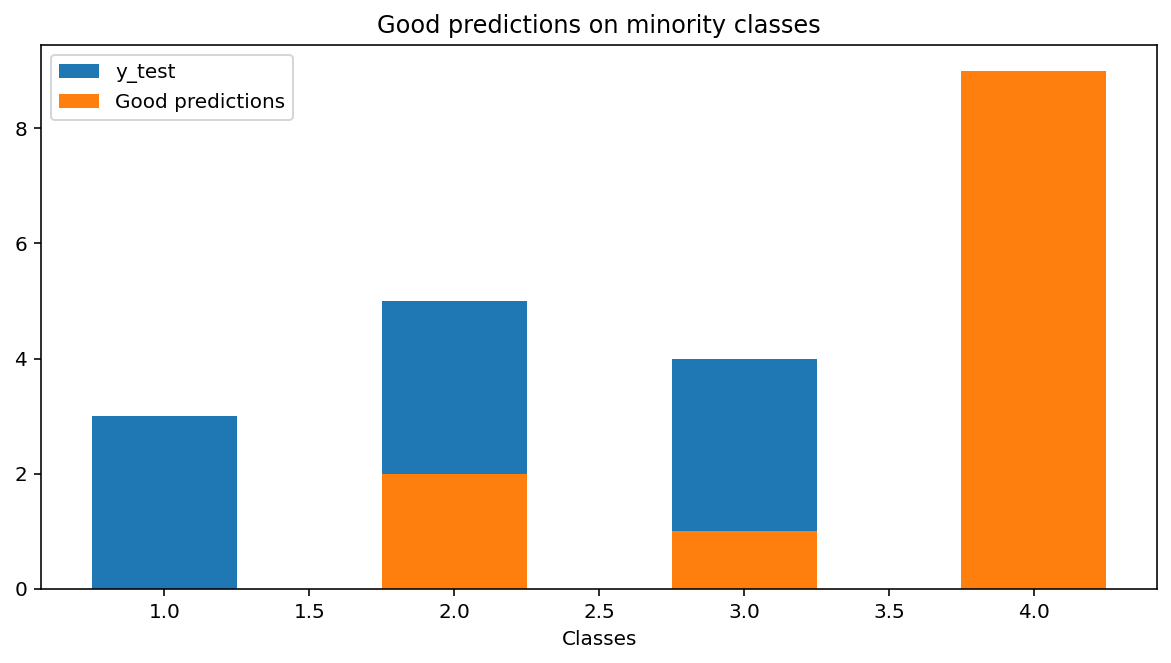

In [139]:
matrix_RF = confusion_matrix(y_test.values, RF_cv.predict(x_test))
acc_class_RF = matrix_RF.diagonal()/matrix_RF.sum(axis=1)
print("The accuracy for each class is: {}".format(acc_class_RF.round(3)))

plt.figure(figsize=(10,5))
plt.hist(y_test[y_test!=0].values,bins=range(1,6), align='left', rwidth=0.5,label='y_test')
plt.bar([1,2,3,4],matrix_RF.diagonal()[1:],color='C1',width = 0.5,label='Good predictions')
plt.xlabel("Classes")
plt.title("Good predictions on minority classes")
plt.legend()
plt.show()

As for Bagging we see that the overall prediction is a bit better. Looking at the accuracy for each class. We worsen the results on the second class while improving a bit the fourth class.

# SVM

## One versus one and one versus rest classifications

We first take a glance at the SVM for the training set without any balancing. We take a look at the two methods: one versus one and one versus the rest.

In [140]:
clf_ovo = SVC(decision_function_shape='ovo')
clf_ovo.fit(x_train, y_train)

clf_ovr = SVC(decision_function_shape='ovr')
clf_ovr.fit(x_train,y_train)

SVC()

In [141]:
print("Accuracy for one vs one: ",clf_ovo.score(x_test, y_test))
print("Accuracy for one vs rest: ",clf_ovr.score(x_test, y_test))

Accuracy for one vs one:  0.943502824858757
Accuracy for one vs rest:  0.943502824858757


We obtain the same results with the two different methods. In the following we use the base method which is one versus one.

## SVM on oversampled dataset

We make the same reasoning using the oversampled dataset. Here the results are better using the data set we created than with the parameter 'balanced'.

In [146]:
%%time
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(x_train_eq, y_train_eq)

CPU times: user 44.5 ms, sys: 2.28 ms, total: 46.7 ms
Wall time: 46.2 ms


SVC()

In [147]:
print("Accuracy for the training set: ",clf_rbf.score(x_train_eq,y_train_eq))
print("Accuracy for the testing set: ",clf_rbf.score(x_test, y_test))

Accuracy for the training set:  0.9962162162162163
Accuracy for the testing set:  0.96045197740113


Here we see that the accuracy is good, better than in the case of Decision Trees. It may be possible to increase a bit the accuracy on the training set by making a cross validation.\
It is also worth to notice that it is not time consuming (less than 1 second of computation).

In [148]:
%%time
param_grid = {'C':np.arange(6,8,0.5)}
clf_rbf_cv = GridSearchCV(SVC(kernel='rbf'), param_grid,cv=5)
clf_rbf_cv.fit(x_train_eq, y_train_eq)
clf_rbf_cv.best_params_

CPU times: user 479 ms, sys: 7.88 ms, total: 487 ms
Wall time: 539 ms


{'C': 7.0}

In [149]:
print("Accuracy for the training set: ",clf_rbf_cv.score(x_train_eq,y_train_eq))
print("Accuracy for the testing set: ",clf_rbf_cv.score(x_test, y_test))

Accuracy for the training set:  1.0
Accuracy for the testing set:  0.9661016949152542


Doing a GridSearch produces a bit of overfitting so we keep the base SVM.

The accuracy for each class is: [0.974 0.667 0.8   0.75  1.   ]


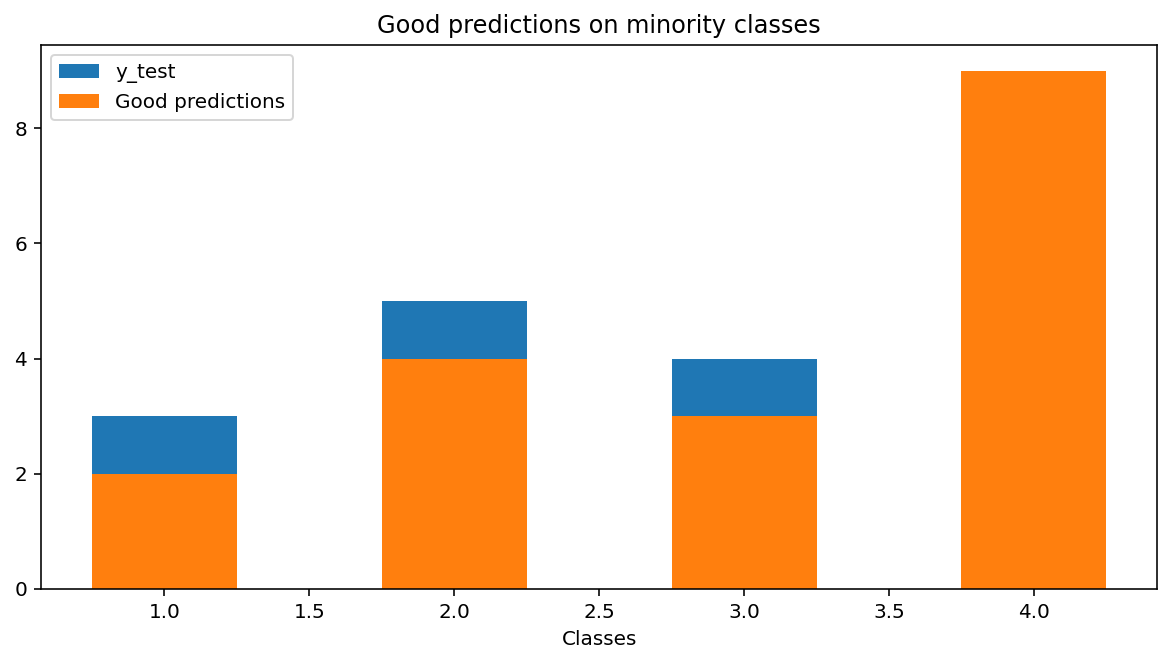

In [150]:
matrix_SVM = confusion_matrix(y_test.values, clf_rbf.predict(x_test))
acc_class_SVM = matrix_SVM.diagonal()/matrix_SVM.sum(axis=1)
print("The accuracy for each class is: {}".format(acc_class_SVM.round(3)))

plt.figure(figsize=(10,5))
plt.hist(y_test[y_test!=0].values,bins=range(1,6), align='left', rwidth=0.5,label='y_test')
plt.bar([1,2,3,4],matrix_SVM.diagonal()[1:],color='C1',width = 0.5,label='Good predictions')
plt.xlabel("Classes")
plt.title("Good predictions on minority classes")
plt.legend()
plt.show()

Compared to the Decision Tree case we see that we increase the overall score on the testing set. Moreover when focusing on each class, we obtain a very good accuracies for the fourth class. For the classes 1, 2 and 3 the score is better than in the case of Decision Trees.\
The SVM classifier perfoms a global and a local better classification.
We can notice a little decrease of the accuracy for the class 0 (the majority class) which is not represented in the bar plot. However this decrease is worth the increase on the minority classes.

# Neural Network

## Pre-processing the data

In [35]:
y_k_train = to_categorical(y_train)
y_k_test = to_categorical(y_test)

## Constructing the model

In [36]:
model = Sequential()

model.add(Dense(300, activation='relu', input_dim=12))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(5, activation='softmax'))

sgd = optimizers.SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train.values)
class_weights = {i:class_weights[i] for i in range(0,5)}

## Training the model

In [38]:
%%time
history = model.fit(x_train, y_k_train, batch_size =8, epochs = 25, validation_data=(x_test, y_k_test),class_weight=class_weights,verbose=1)

Epoch 1/25
52/52 [==============================] - 2s 20ms/step - loss: 1.6993 - accuracy: 0.4779 - val_loss: 1.1655 - val_accuracy: 0.8079
Epoch 2/25
52/52 [==============================] - 0s 7ms/step - loss: 0.9605 - accuracy: 0.7764 - val_loss: 1.0239 - val_accuracy: 0.8588
Epoch 3/25
52/52 [==============================] - 0s 7ms/step - loss: 0.7875 - accuracy: 0.8946 - val_loss: 0.8200 - val_accuracy: 0.8531
Epoch 4/25
52/52 [==============================] - 0s 5ms/step - loss: 0.5790 - accuracy: 0.8889 - val_loss: 0.5299 - val_accuracy: 0.9605
Epoch 5/25
52/52 [==============================] - 0s 5ms/step - loss: 0.5943 - accuracy: 0.9329 - val_loss: 0.4350 - val_accuracy: 0.9492
Epoch 6/25
52/52 [==============================] - 0s 5ms/step - loss: 0.3378 - accuracy: 0.9418 - val_loss: 0.3645 - val_accuracy: 0.9661
Epoch 7/25
52/52 [==============================] - 0s 6ms/step - loss: 0.3512 - accuracy: 0.9337 - val_loss: 0.3035 - val_accuracy: 0.9605
Epoch 8/25
52/52 [=

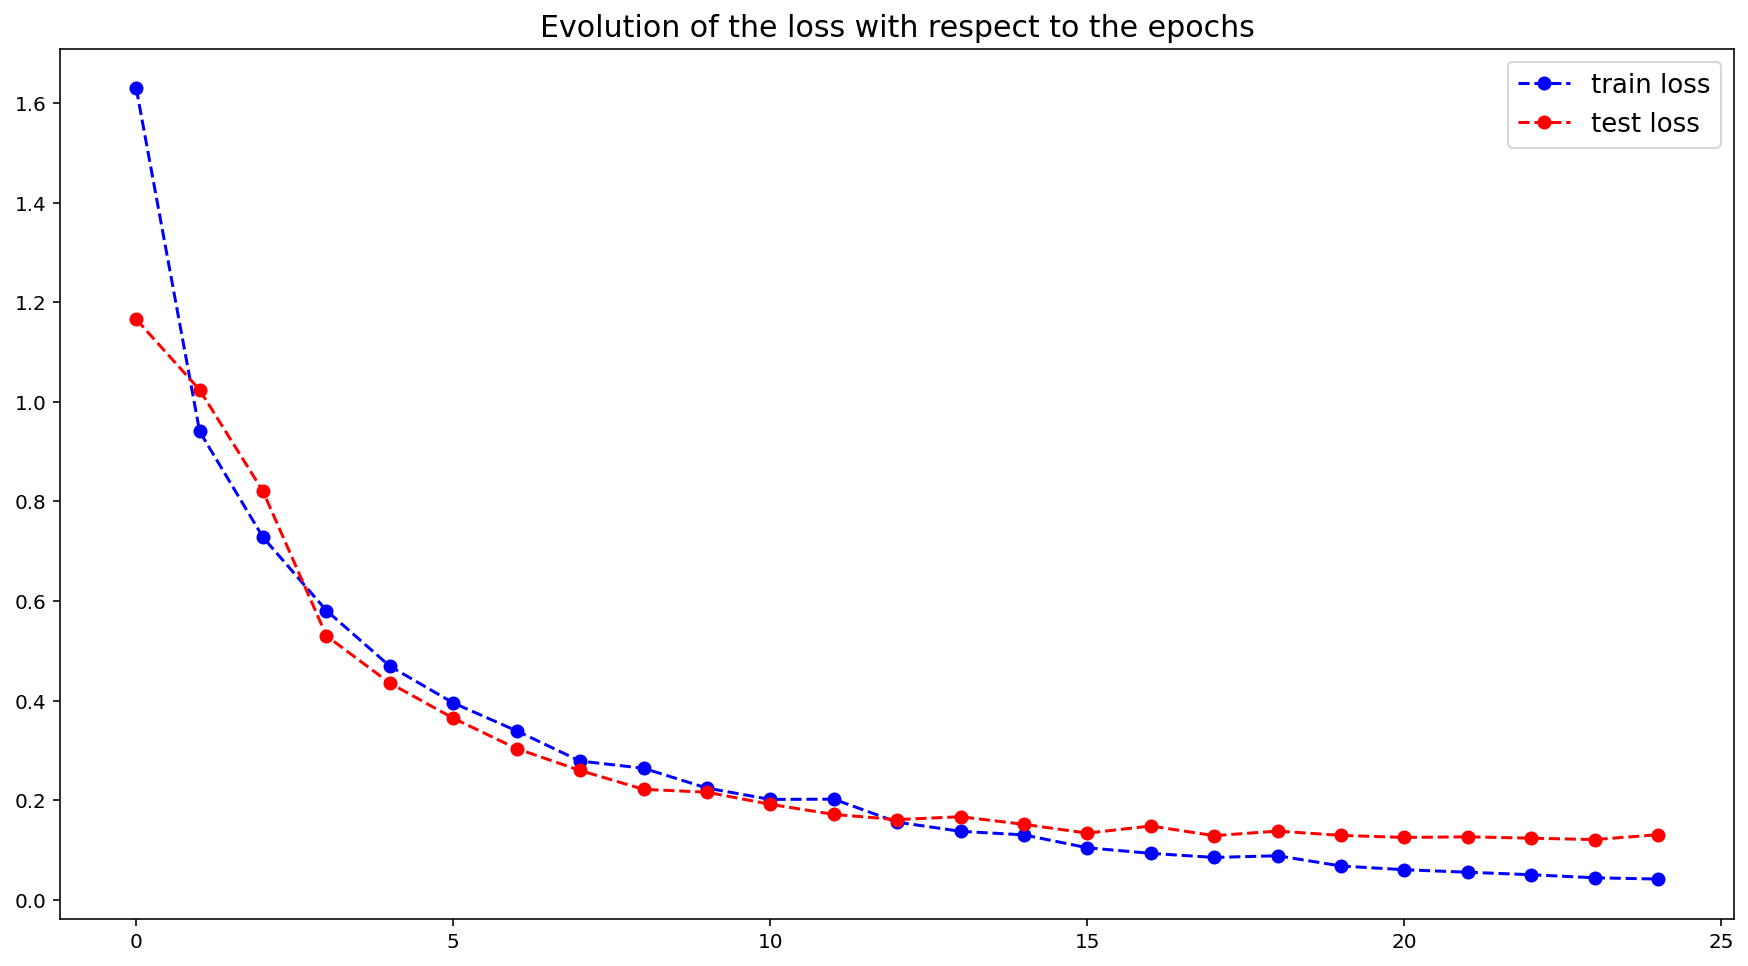

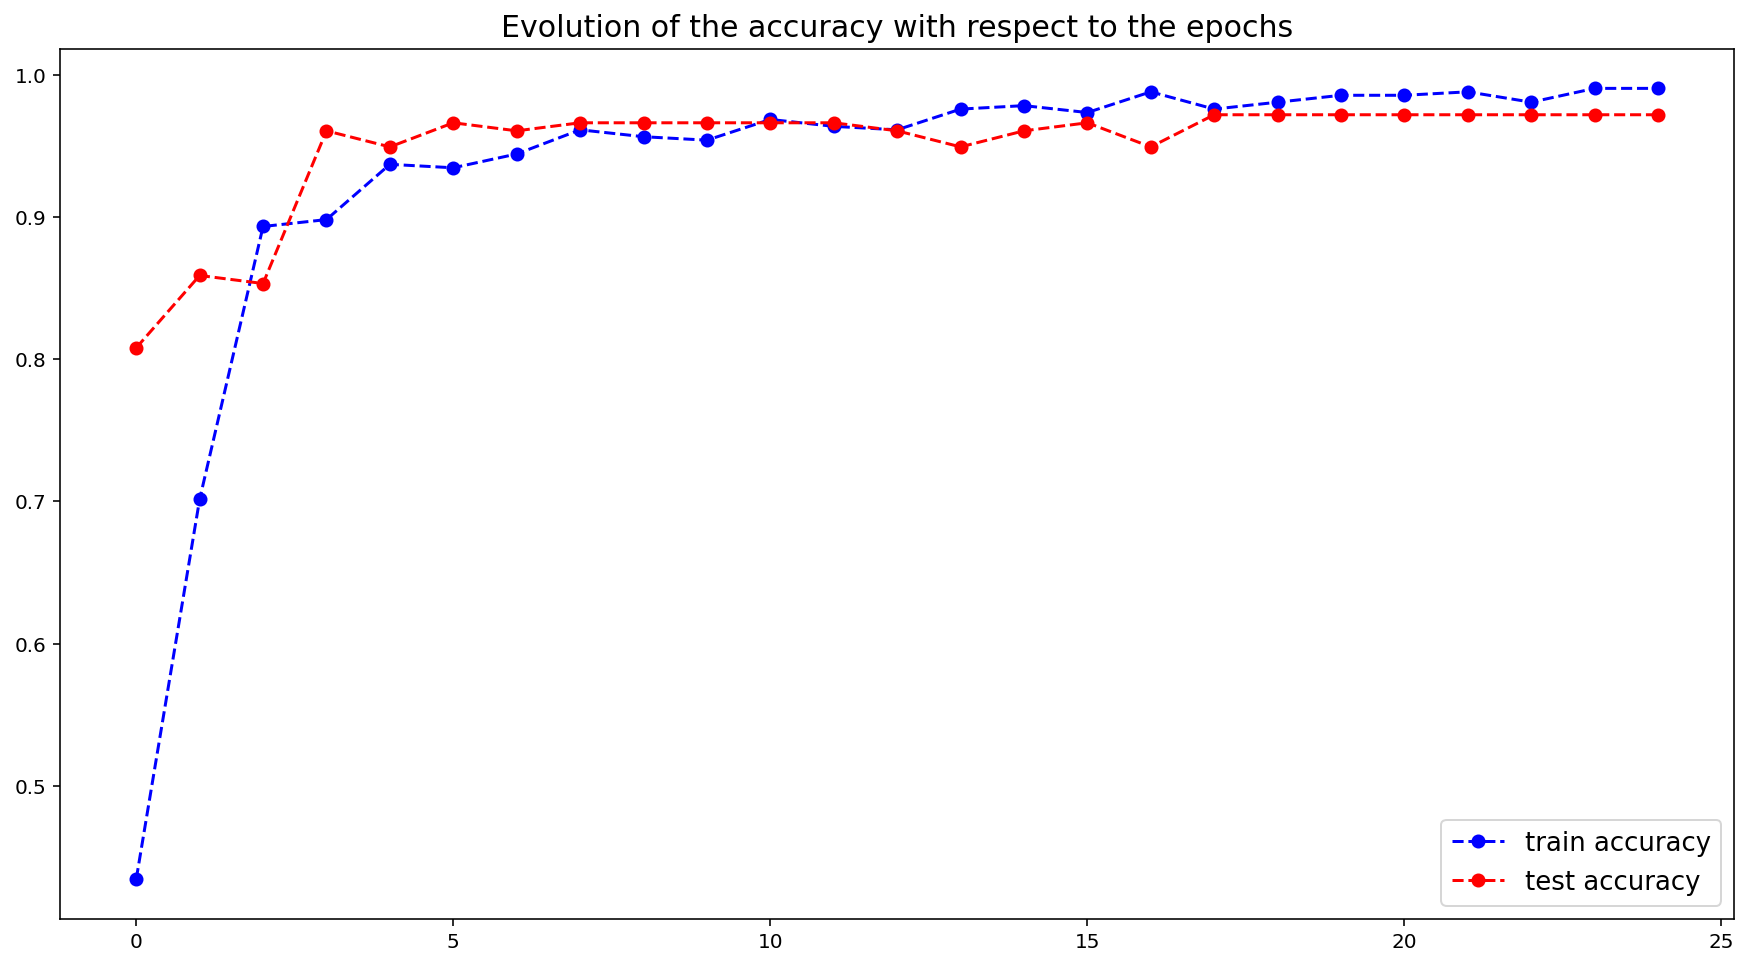

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.figure(figsize=(15,8))
plt.plot(loss, c='b', marker='o', linestyle='--', label='train loss')
plt.plot(val_loss, c='r', marker='o', linestyle='--', label='test loss')
plt.title('Evolution of the loss with respect to the epochs', size=15)
plt.legend(fontsize=13)
plt.show()

plt.figure(figsize=(15,8))
plt.plot(accuracy, c='b', marker='o', linestyle='--', label='train accuracy')
plt.plot(val_accuracy, c='r', marker='o', linestyle='--', label='test accuracy')
plt.title('Evolution of the accuracy with respect to the epochs', size=15)
plt.legend(fontsize=13)
plt.show()

The accuracy for each class is: [0.994 0.667 0.8   0.5   1.   ]


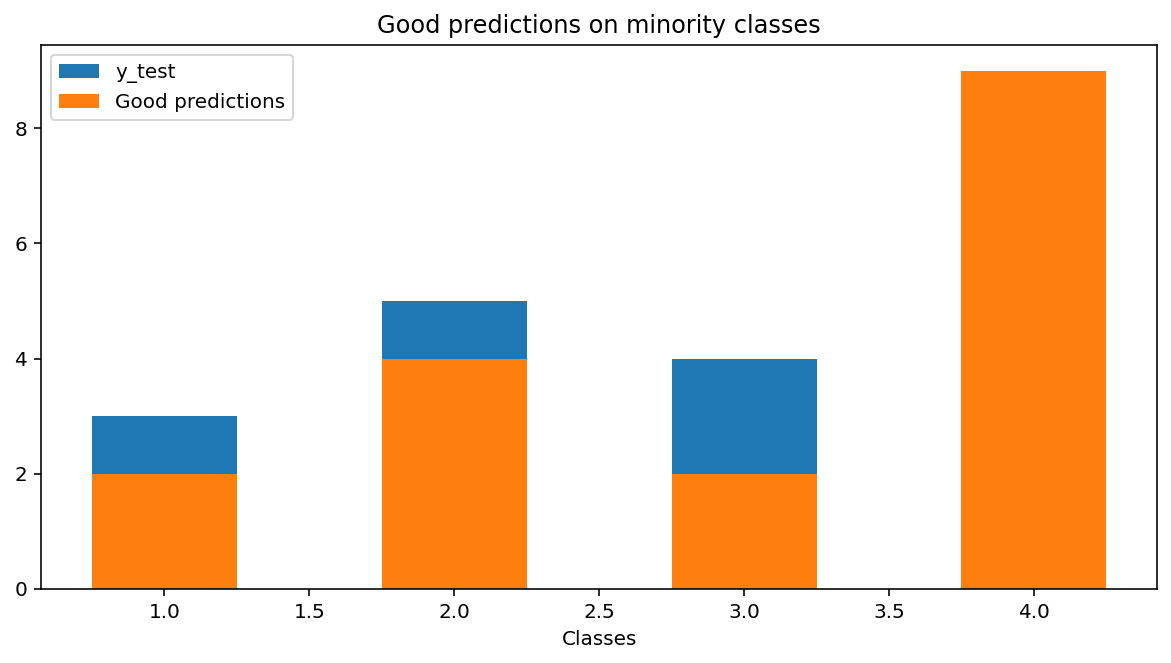

In [40]:
matrix_NN = confusion_matrix(y_test.values, np.argmax(model.predict(x_test),axis=1))
acc_class_NN = matrix_NN.diagonal()/matrix_NN.sum(axis=1)
print("The accuracy for each class is: {}".format(acc_class_NN.round(3)))

plt.figure(figsize=(10,5))
plt.hist(y_test[y_test!=0].values,bins=range(1,6), align='left', rwidth=0.5,label='y_test')
plt.bar([1,2,3,4],matrix_NN.diagonal()[1:],color='C1',width = 0.5,label='Good predictions')
plt.xlabel("Classes")
plt.title("Good predictions on minority classes")
plt.legend()
plt.show()

Here again, the performances are better than in the case of Decision Trees. Even though the overall testing accuracy has increased compared to SVM, the computation is much more time consuming. Between This NN and the SVM one might choose SVM for the speed-result ratio.

**Conclusion**\
Before concluding on this multiclassification task, it is important to be careful on the fact that our results depends a lot on the initial data split. We tried to have a good repartition in term of minority classes, but results could diverge with another split.\
Concerning classifier:\
> **Decision Tree**: the base results are not that bad but they mainly comes from the fact that we have a good prediction for the class 0 and average prediction for the minority classes. When we plot the tree we see that the class 1 (which is the class 0s in the dataset) is fully determined at the root split. The ensemble methods on decision trees improve slightly the results but we still lack precision for the minority classes\
> **SVM**:\
> **NN**: